In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torchvision.utils as vutils

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cpu')

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):

        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = loss
            self.counter = 0

In [5]:

class GAN(nn.Module):
    def __init__(self, generator, discriminator, train_loader, num_epochs, input_dim, g_learning_rate, d_learning_rate, patience):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.num_epochs = num_epochs
        self.input_dim = input_dim
        self.g_learning_rate = g_learning_rate
        self.d_learning_rate = d_learning_rate
        self.patience = patience
        self.early_stopping = EarlyStopping(patience=patience)
        self.train_loader = train_loader

    def noiser(self, batch_size, dim, device, mu=0, sigma=1):
        noise = torch.randn(batch_size, dim, device=device) * sigma + mu
        return noise

    def train_gan(self):
        optimizer_G = optim.Adam(self.generator.parameters(), lr=self.g_learning_rate, betas=(0.5, 0.999))
        optimizer_D = optim.Adam(self.discriminator.parameters(), lr=self.d_learning_rate, betas=(0.5, 0.999))

        for epoch in range(self.num_epochs):
            g_losses = []
            d_losses = []
            for i, (images, _) in enumerate(self.train_loader):
                images = images.to(device)
                batch_size = images.size(0)
                real_labels = torch.ones(batch_size, 1, device=device)
                fake_labels = -torch.ones(batch_size, 1, device=device)

                optimizer_G.zero_grad()
                generated_images = self.generator(self.noiser(batch_size=batch_size, dim=self.input_dim, device=device))
                g_loss = -torch.mean(self.discriminator(generated_images))
                g_loss.backward()
                optimizer_G.step()

                optimizer_D.zero_grad()
                real_loss = torch.mean(F.relu(1 - self.discriminator(images)))
                fake_loss = torch.mean(F.relu(1 + self.discriminator(generated_images.detach())))
                d_loss = real_loss + fake_loss
                d_loss.backward()
                optimizer_D.step()

                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())

            g_loss_mean = sum(g_losses) / len(g_losses)
            d_loss_mean = sum(d_losses) / len(d_losses)

            print(f"Epoch [{epoch}/{self.num_epochs}], d_loss_mean: {d_loss_mean}, g_loss_mean: {g_loss_mean}")

            self.early_stopping(d_loss_mean)
            if self.early_stopping.early_stop:
                print("Early stopping triggered.")
                break

            plt.figure(figsize=(10, 10))
            plt.axis("off")
            plt.title("Generated Images")
            plt.imshow(np.transpose(vutils.make_grid(generated_images.to("cpu"), padding=2, normalize=True).cpu(), (1, 2, 0)))
            plt.show()


In [15]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        self.register_buffer('running_mean',torch.zeros(num_features))
        self.register_buffer('running_var',torch.ones(num_features))

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, unbiased=False, keepdim=True)

            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.squeeze()
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var.squeeze()
        else:
            mean = self.running_mean.unsqueeze(0)
            var = self.running_var.unsqueeze(0)

        x = (x - mean) / torch.sqrt(var + self.eps)
        x = self.gamma * x + self.beta
        return x

In [17]:
class GeneratorLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GeneratorLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 2048)
        self.fc5 = nn.Linear(2048, output_dim)
        self.bn1 = BatchNorm(256)
        self.bn2 = BatchNorm(512)
        self.bn3 = BatchNorm(1024)
        self.bn4 = BatchNorm(2048)

    def forward(self, noise):
        x = F.relu(self.bn1(self.fc1(noise)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = torch.tanh(self.fc5(x))
        x = x.view(-1, 3, 32, 32)
        return x


In [9]:
class DiscriminatorLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DiscriminatorLayer, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)
        self.dropout = nn.Dropout2d(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = torch.sigmoid(self.fc3(x))
        return x


In [10]:
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.RandomAutocontrast(p=0.4),
    v2.RandomVerticalFlip(p=0.3),
    v2.ToTensor(),
    v2.Normalize((0.5,), (0.5,), (0.5,))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 170498071/170498071 [00:02<00:00, 61176688.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [11]:
train_data.data.shape

(50000, 32, 32, 3)

In [12]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

<ipython-input-13-5df6843dd84c>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, n, i+1)


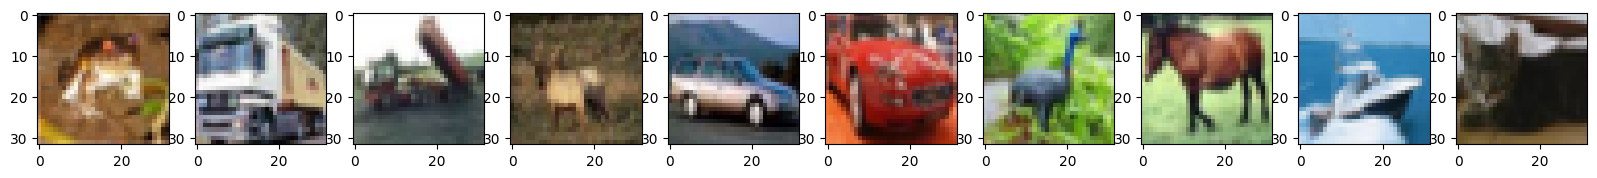

In [13]:
def imshow(img, n):
    plt.figure(figsize=(20, 10))
    plt.axis('off')
    for i in range(n):
        plt.subplot(2, n, i+1)
        npimg = img[i]
        plt.imshow(npimg, cmap='YlGn', interpolation='nearest')
    plt.show()

imshow(train_data.data,10)

Epoch [0/10], d_loss_mean: 1.0979122472236225, g_loss_mean: -0.07016388665993085


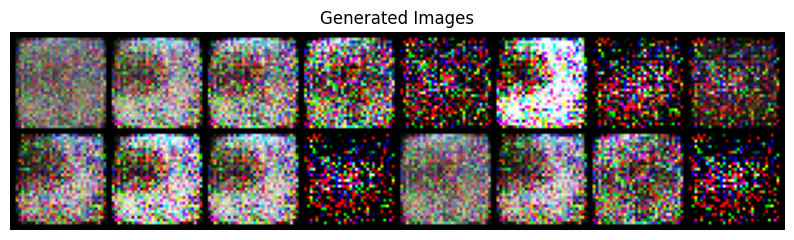

Epoch [1/10], d_loss_mean: 1.1249219352936806, g_loss_mean: -0.06442389081443081


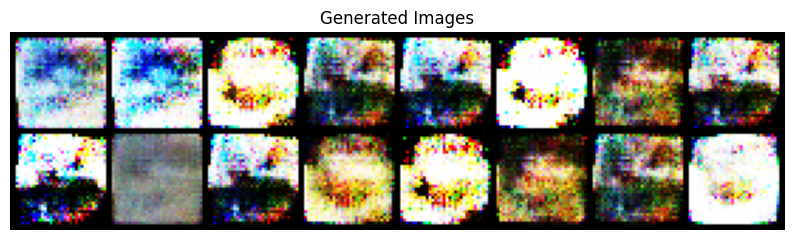

KeyboardInterrupt: 

In [18]:
num_epochs = 10
input_dim =  100
output_dim = 32 * 32 * 3
g_learning_rate = 0.0002
d_learning_rate = 0.0001
patience = 30

generator = GeneratorLayer(input_dim=input_dim, output_dim=output_dim).to(device)
discriminator = DiscriminatorLayer(input_dim=output_dim, output_dim=1).to(device)

gan = GAN(generator, discriminator,train_loader=train_loader, num_epochs=num_epochs, input_dim=input_dim,
          g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate, patience=patience).to(device)

gan.train_gan()
